# IMPORTING LIBRARIES

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib Inline
import plotly.express as px
sns.set()
import os
import sklearn


In [277]:
from google.colab import drive
drive.mount('/content/drive')
cord_19 = os.path.abspath('/content/drive/MyDrive/AI/covid_19_clean_complete.csv')
cord_19_2 = os.path.abspath('/content/drive/MyDrive/AI/day_wise.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [278]:
data  = pd.read_csv(cord_19)
data.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa
5,NaN,Antigua and Barbuda,17.06080,-61.796400,2020-01-22,0,0,0,0,Americas
6,NaN,Argentina,-38.41610,-63.616700,2020-01-22,0,0,0,0,Americas
7,NaN,Armenia,40.06910,45.038200,2020-01-22,0,0,0,0,Europe
8,Australian Capital Territory,Australia,-35.47350,149.012400,2020-01-22,0,0,0,0,Western Pacific
9,New South Wales,Australia,-33.86880,151.209300,2020-01-22,0,0,0,0,Western Pacific


In [279]:
#Handling missing values
data.fillna(method='ffill', inplace=True)

<ipython-input-279-e7569867ed66>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [280]:
data.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa
5,NaN,Antigua and Barbuda,17.06080,-61.796400,2020-01-22,0,0,0,0,Americas
6,NaN,Argentina,-38.41610,-63.616700,2020-01-22,0,0,0,0,Americas
7,NaN,Armenia,40.06910,45.038200,2020-01-22,0,0,0,0,Europe
8,Australian Capital Territory,Australia,-35.47350,149.012400,2020-01-22,0,0,0,0,Western Pacific
9,New South Wales,Australia,-33.86880,151.209300,2020-01-22,0,0,0,0,Western Pacific


In [281]:
# Converting Date Column To DateTime Format
data['Date'] = pd.to_datetime(data['Date'])

# PERFORMING FEATURE ENGINERRING

In [282]:
data['Daily_Cases'] = data['Confirmed'].diff()
data['Mortality_Rate'] = data['Deaths'] / data['Confirmed']

# PLOTTING TIME SERIES FOR CONFIRMED CASES

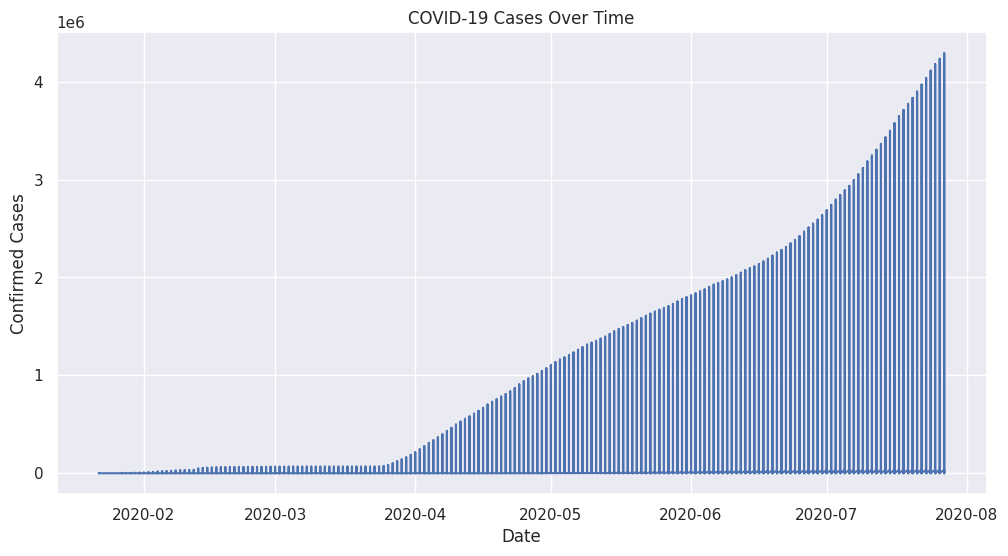

In [283]:
# Time series plot of confirmed cases
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Confirmed'])
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Cases Over Time')
plt.show()


# CALCULATING COUNTS OF NUMBER OF CASES FOR EACH COUNTRY

In [284]:
country_counts = data['Country/Region'].value_counts().reset_index()
country_counts.columns = ['Country/Region', 'Count']
country_counts.columns

Index(['Country/Region', 'Count'], dtype='object')

In [285]:
# Calculate IQR to find outliers
Q1 = country_counts['Count'].quantile(0.25)
Q3 = country_counts['Count'].quantile(0.75)
IQR = Q3 - Q1
IQR

0.0

In [286]:
# Define outliers
outliers = country_counts[(country_counts['Count'] < (Q1 - 1.5 * IQR)) | (country_counts['Count'] > (Q3 + 1.5 * IQR))]
outliers

,Country/Region,Count
0,China,6204
1,Canada,2256
2,France,2068
3,United Kingdom,2068
4,Australia,1504
5,Netherlands,752
6,Denmark,376


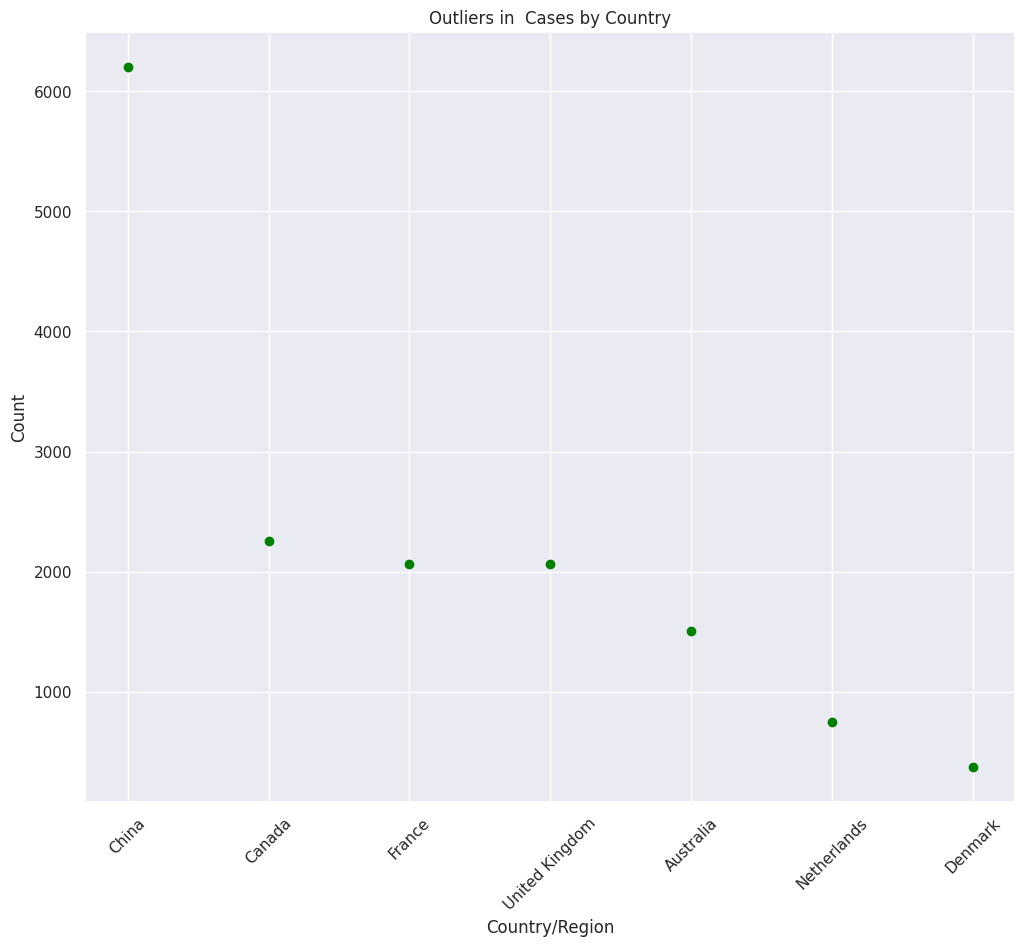

In [287]:
# Plot only outliers
plt.figure(figsize=(12, 10))
plt.scatter(outliers['Country/Region'], outliers['Count'], color='green')
plt.xticks(rotation=45)
plt.xlabel('Country/Region')
plt.ylabel('Count')
plt.title('Outliers in  Cases by Country')
plt.show()

# DROPPING UNWANTED COLUMNS(LOGITUDE AND LATITUDE COLUMNS)

In [288]:
# Removing 'longitude' and 'latitude' columns
filtered_data = data.drop(columns=['Long', 'Lat'])

# DISPLAYING THE CORRELATIONSHIP BETWEEN THE COLUMNS USING HEATMAP

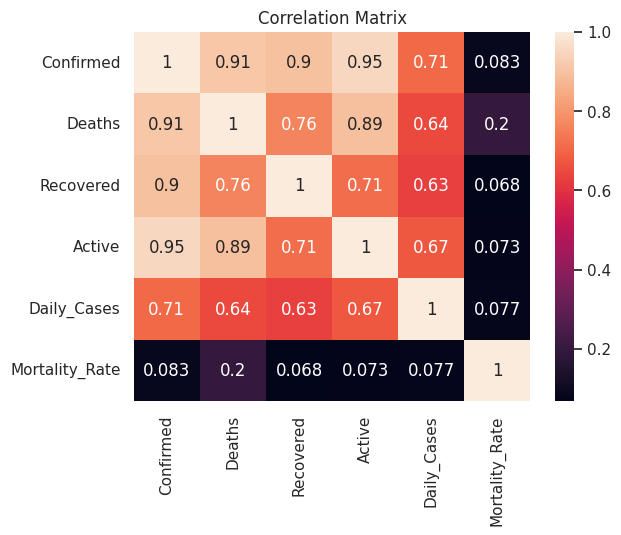

In [289]:
# Correlation matrix
corr_matrix = filtered_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# IMPORTING MODEL LIBRARIES

In [290]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from datetime import datetime


In [291]:
data2 = pd.read_csv(cord_19_2)
data2.head(10)

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13
5,2020-01-27,2927,82,61,2784,809,26,9,2.80,2.08,134.43,16
6,2020-01-28,5578,131,107,5340,2651,49,46,2.35,1.92,122.43,16
7,2020-01-29,6166,133,125,5908,588,2,18,2.16,2.03,106.40,18
8,2020-01-30,8234,171,141,7922,2068,38,16,2.08,1.71,121.28,20
9,2020-01-31,9927,213,219,9495,1693,42,78,2.15,2.21,97.26,24


In [292]:
# Set 'Date' as the index
data2.set_index('Date', inplace=True)

In [293]:
# Use 'Confirmed' cases as the target variable
confirmed_cases = data2['Confirmed']


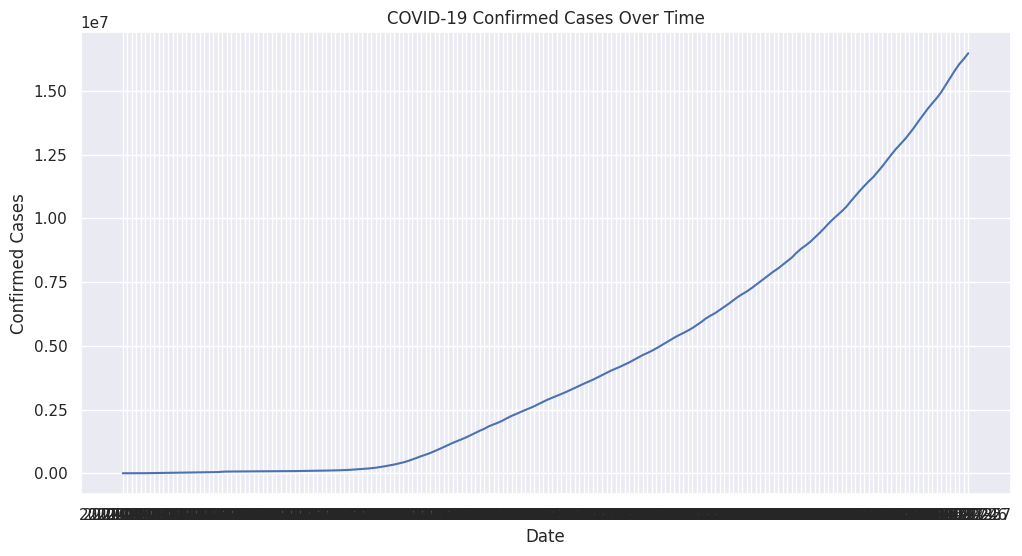

In [294]:
# Visualizing the Confirmed cases over time
plt.figure(figsize=(12, 6))
plt.plot(confirmed_cases)
plt.title('COVID-19 Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()

# SPLITTING THE DATA INTO TRAINNING AND TESTING DATA

In [295]:
# Spliting data into training and testing (80-20 split)
train_size = int(len(confirmed_cases) * 0.8)
train, test = confirmed_cases[:train_size], confirmed_cases[train_size:]


# BUILDING THE MODEL USING A TIME-SERIES MODEL CALLED ARIMA (AUTOREGRESSIVE INTEGRATED MOVING AVERAGE).

In [296]:
# Building the ARIMA model on the training set
#  tunning the (p, d, q) parameters to get the best results
model = ARIMA(train, order=(5, 1, 0))  # p=5, d=1, q=0 are common initial guesses


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [297]:
# fitting the model
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [298]:
# Getting the summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  150
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1554.830
Date:                Tue, 26 Nov 2024   AIC                           3121.661
Time:                        14:27:12   BIC                           3139.685
Sample:                    01-22-2020   HQIC                          3128.984
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8361      0.067     12.551      0.000       0.706       0.967
ar.L2         -0.0823      0.097     -0.846      0.397      -0.273       0.108
ar.L3          0.1326      0.094      1.416      0.1

In [299]:
# Predicting Using  the test set
Prediction = model_fit.predict(steps=len(test))

In [300]:
Prediction

,predicted_mean
2020-01-22,0.000000e+00
2020-01-23,1.110000e+03
2020-01-24,8.022715e+02
2020-01-25,1.288609e+03
2020-01-26,1.895409e+03
...,...
2020-06-15,8.056363e+06
2020-06-16,8.167662e+06
2020-06-17,8.325096e+06
2020-06-18,8.465644e+06


# PLOTTING THE ACTUAL VALUES AGAINST THE PREDICTED VALUES.

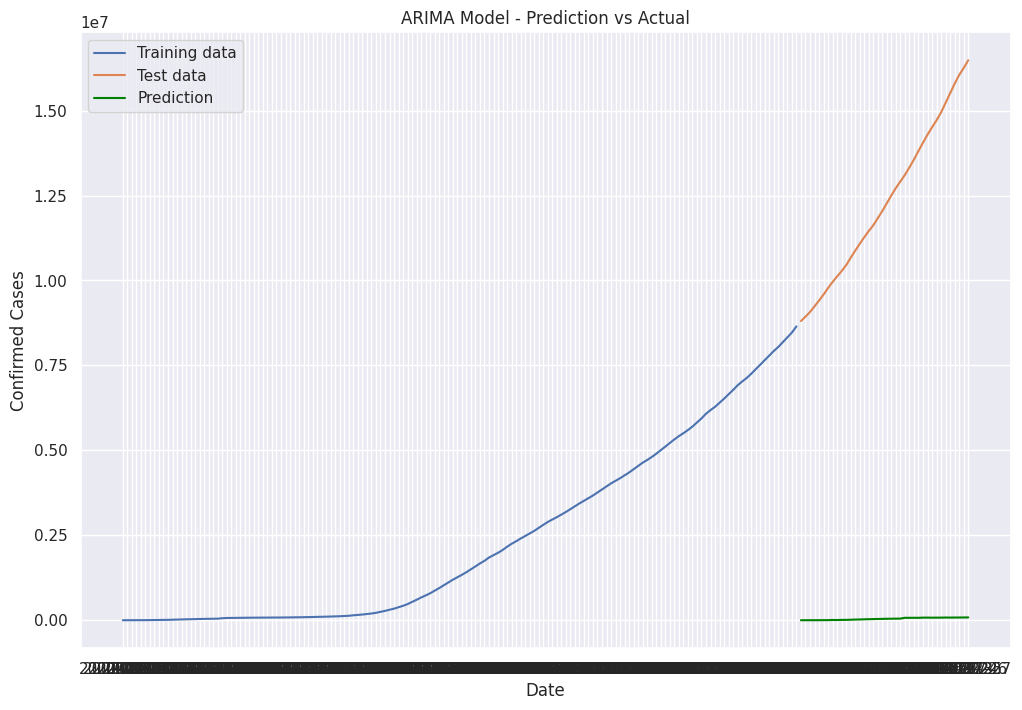

In [301]:
# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.plot(train, label='Training data')
plt.plot(test.index, test, label='Test data')
# Changing Prediction to Prediction[:len(test)] to match the lengths
plt.plot(test.index, Prediction[:len(test)], label='Prediction', color='green')
plt.title('ARIMA Model - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# EVALUATING THE MODEL PERFORMANCE USING THE THE  ROOT MEAN SQUARED ERROR(RMSE)

In [302]:
# Evaluate model using RMSE
error = rmse(test, Prediction[:len(test)])
print(f'Root Mean Squared Error (RMSE): {error}')



Root Mean Squared Error (RMSE): 12494743.281955453


# PREDICTING COVID _19 CASES IN  THE FUTURE

In [303]:
# Covid_19 Future Prediction (next 20 days)
future_steps = 20
future_prediction = model_fit.predict(steps=future_steps)

# VISSUALIZING FUTURE PREDICTIONS OF COVID_19 CASES.

In [304]:
future_dates = pd.date_range(start=pd.to_datetime(test.index[-1]) + pd.Timedelta(days=1), periods=future_steps, freq='D')

In [305]:
future_dates_num = mdates.date2num(future_dates)
future_prediction = future_prediction[-future_steps:]

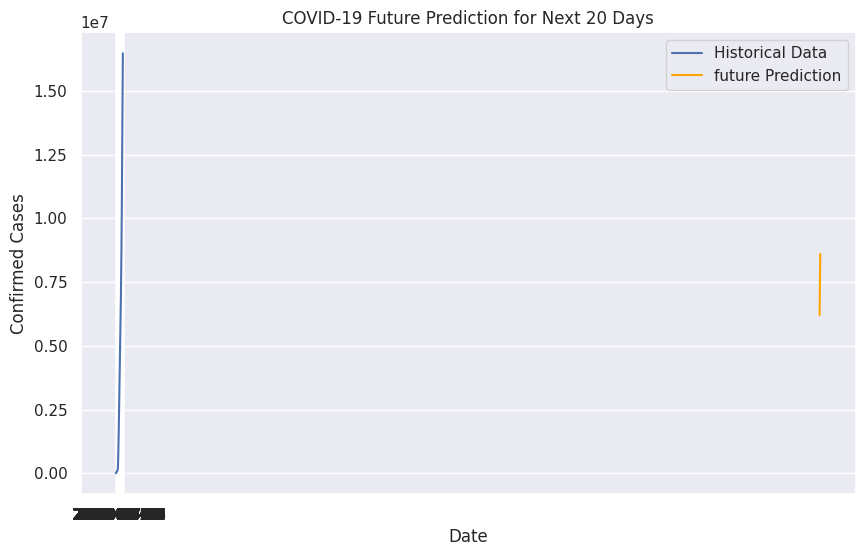

In [306]:
plt.figure(figsize=(10, 6))
plt.plot(confirmed_cases.index, confirmed_cases.values, label='Historical Data')
plt.plot(future_dates_num, future_prediction, label='future Prediction', color='orange')
plt.title('COVID-19 Future Prediction for Next 20 Days')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate() # Auto-format dates for better readability
plt.legend()
plt.show()

In [307]:
future_dates_num = mdates.date2num(future_dates)

In [308]:
future_prediction = future_prediction[-future_steps:]

Text(0, 0.5, 'Confirmed Cases')

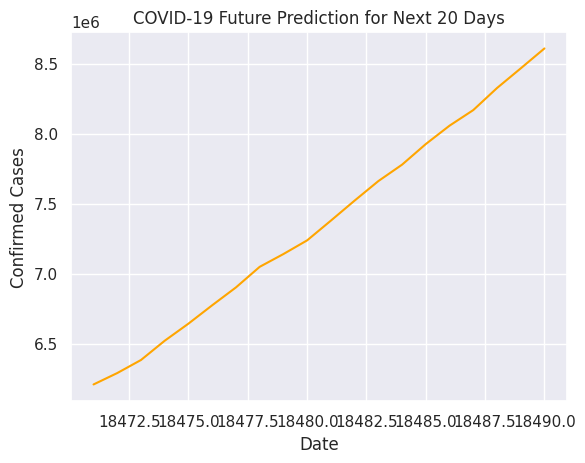

In [309]:
plt.plot(future_dates_num, future_prediction, label='future Prediction', color='orange')
plt.title('COVID-19 Future Prediction for Next 20 Days')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')

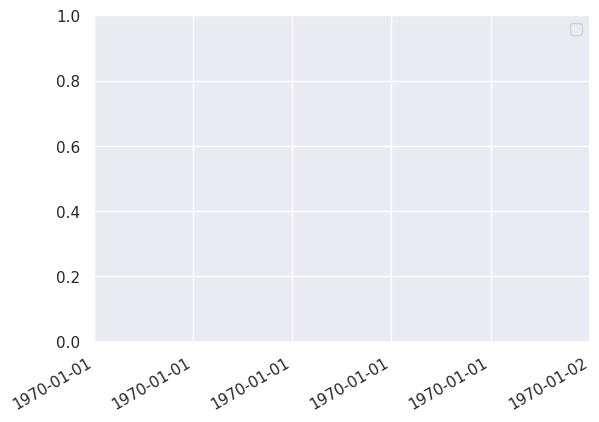

In [310]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Auto-format dates for better readability
plt.legend()
plt.show()

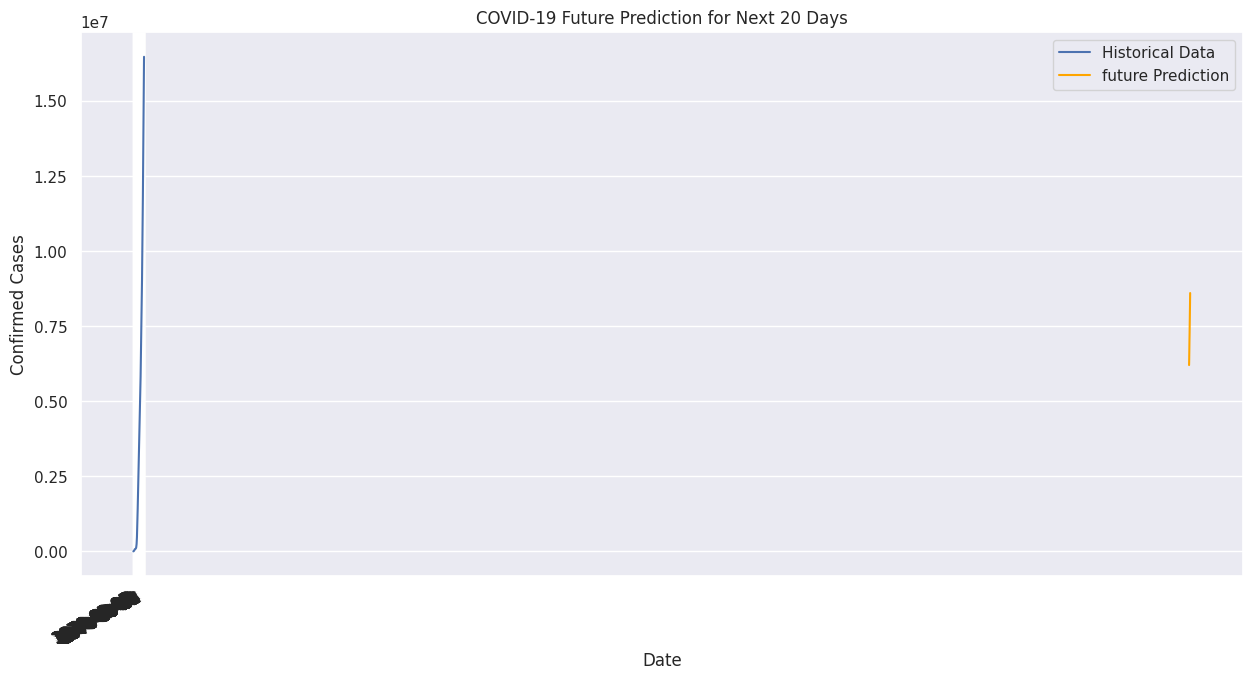

In [311]:

import matplotlib.dates as mdates

# ... (Your existing code to calculate future_dates and future_prediction) ...

# Plotting future covid_19 cases
# Convert test.index[-1] to a datetime object before adding the Timedelta


plt.figure(figsize=(15, 8))
plt.plot(confirmed_cases.index, confirmed_cases.values, label='Historical Data')  # Plot with index for x-axis
# Convert future_dates to matplotlib dates
future_dates_num = mdates.date2num(future_dates)

# Adjust the length of future_prediction to match future_dates_num
future_prediction = future_prediction[-future_steps:]  # Select the last 'future_steps' elements

plt.plot(future_dates_num, future_prediction, label='future Prediction', color='orange')
plt.title('COVID-19 Future Prediction for Next 20 Days')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
# Format x-axis to display dates correctly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Auto-format dates for better readability
plt.legend()
plt.show()